## Data Preprocessing

In [1]:
import os

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
for dirname, sub_dirs, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


In [2]:
import glob  # finds all the pathnames matching X
import zipfile
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch

torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F  # handy functions (e.g. we don't have to write 'relu' ourselves)
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, CenterCrop

In [3]:
# Where's the data?
input_dir = "/kaggle/input/carvana-image-masking-challenge/"

In [4]:
# Now, unzip our data
import time
start_time = time.time()

with zipfile.ZipFile(input_dir + "train.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
print("Train done")

with zipfile.ZipFile(input_dir + "train_masks.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
print("Masks done")

with zipfile.ZipFile(input_dir + "sample_submission.csv.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
print("CSV done")

# with zipfile.ZipFile(input_dir + "test.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")
# print("Test done")

t1 = time.time() - start_time
print("\n--- %s seconds ---" % t1)
# t2 = t1 / 60
# print("\n--- %s minutes ---" % t2)


--- 191.30200290679932 seconds ---


## Get just the filenames

```python
all_images = [s.split("/")[-1]
              .split(".")[0]
              for s in train_val_images]
```

This creates a new list called `all_images` by iterating over the elements in the `train_val_images` list. For each element in the `train_val_images` list, the code performs the following operations:

1. It splits the element by the forward slash ("/") separator using the `split("/")` method.
2. It takes the last element of the resulting list using the `[-1]` index.
3. It splits the resulting string by the period (".") separator using the `split(".")` method.
4. It takes the first element of the resulting list using the `[0]` index.

The end result is a new list of strings called `all_images`, where each string is the filename of an image in the `train_val_images` list without the file extension.

For example, if `train_val_images` contained the string `"path/to/image1.jpg"`, the corresponding element in `all_images` would be `"image1"`.

### Real Example:

```python
blah = train_val_images[0]  # I just want 1 for this example
# blah.split("/")  # ['00087a6bd4dc_01']
# blah.split("/")[-1]  # '00087a6bd4dc_01'
blah.split("/")[-1].split(".")[0]  # remove .ext (if there is one!)
```

In [5]:
# search for files in the train folder
train_val_images = glob.glob("train/*")

# sort the list of files
train_val_images = sorted(train_val_images)

# Get list of images without file extension
all_images = [s.split("/")[-1].split(".")[0] for s in train_val_images]

# Grab a subset of the images
to_train = 0.25  # 1
train_val_images = all_images[:int(len(all_images) * to_train)]

print(f"\nThere are {len(train_val_images)} images to do.")



There are 1272 images.


In [6]:
# We get an example submission file.
# Our file should look like that.
sample_sub = pd.read_csv("sample_submission.csv")

sample_sub.head(2)

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1


In [7]:
# Split matrix into random train and test subsets.
train_images, val_images = train_test_split(train_val_images, test_size=0.1, random_state=42)

# test_images = sample_sub.img.to_numpy()

print(f"\nTraining: {len(train_images)}, Validation: {len(val_images)}")


Training: 1144, Validation: 128


In [8]:
train_images[0], val_images[0]  #, test_images[0]

('0ee135a3cccc_01', '0de66245f268_01', '0004d4463b50_01.jpg')

## Create Model

In [9]:
# INPUT_SIZE
img_size = 576

# [4, 3, 576, 576]


class CustomImageDataset(Dataset):
    """
    Resize, convert to grayscale, transform
    """
    def __init__(self, img_ids, transform=None):
        self.img_ids = img_ids
        self.transform = transform  # ToTensor

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        # WE KNOW THIS AHEAD OF TIME
        img_path = "train/" + img_id + ".jpg"
        mask_path = "train_masks/" + img_id + "_mask.gif"

        image = Image.open(img_path)
        image = image.resize((img_size, img_size))

        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((img_size, img_size))

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [10]:
# Convert train_images list to CustomImageDataset
training_data = CustomImageDataset(train_images, ToTensor())

# Convert val_images
val_data = CustomImageDataset(val_images, ToTensor())



Before: <class 'list'>

After: <class '__main__.CustomImageDataset'>


In [11]:
# Iterate the training data in order to see what it is
for x, y in training_data:
    print("\nimage:", x.shape)  # INPUT SIZE
    print("\nmask:", y.shape)
    break


image: torch.Size([3, 576, 576])

mask: torch.Size([1, 576, 576])


In [12]:
# Make DataLoaders and shuffle images
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True)

In [13]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor):
        return self.block(x)


class CopyAndCrop(nn.Module):
    def forward(self, x: torch.Tensor, encoded: torch.Tensor):
        _, _, h, w = encoded.shape
        crop = CenterCrop((h, w))(x)
        output = torch.cat((x, crop), 1)

        return output

## Model 1

In [14]:
class UNet(nn.Module):
    """
    Model 1
    """
    def __init__(self, in_channels: int, out_channels: int):
        super(UNet, self).__init__()

        self.encoders = nn.ModuleList([
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        ])

        self.down_sample = nn.MaxPool2d(2)

        self.copyAndCrop = CopyAndCrop()

        self.decoders = nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
        ])

        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])

        self.bottleneck = ConvBlock(512, 1024)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)

    def forward(self, x: torch.Tensor):
        # print('Input size:', x.size())

        # encode
        encoded_features = []
        for enc in self.encoders:
            x = enc(x)
            encoded_features.append(x)
            x = self.down_sample(x)

        x = self.bottleneck(x)

        # decode
        for idx, denc in enumerate(self.decoders):
            x = self.up_samples[idx](x)
            encoded = encoded_features.pop()
            x = self.copyAndCrop(x, encoded)
            x = denc(x)

        output = self.final_conv(x)
        return output


# create an instance of the model
model = UNet(in_channels=3, out_channels=1).to(device)
print(model)

UNet(
  (encoders): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      

## Model 2

In [16]:
# Input size: torch.Size([4, 3, 576, 576])

# class UNet(nn.Module):
#     """
#     Model 2
#     """
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

#         self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
#         self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

#         self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
#         self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

#         self.conv9 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
#         self.conv10 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1)

#         self.upconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)

#         self.conv11 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)
#         self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

#         self.upconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)

#         self.conv13 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
#         self.conv14 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

#         self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

#         self.conv15 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
#         self.conv16 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

#         self.upconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

#         self.conv17 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
#         self.conv18 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

#         self.finalconv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))

#         crop1 = CenterCrop((img_size, img_size))(x)

#         x = F.relu(self.pool(x))

#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))

#         crop2 = CenterCrop((img_size // 2, img_size // 2))(x)

#         x = F.relu(self.pool(x))

#         x = F.relu(self.conv5(x))
#         x = F.relu(self.conv6(x))

#         crop3 = CenterCrop((img_size // 4, img_size // 4))(x)

#         x = F.relu(self.pool(x))

#         x = F.relu(self.conv7(x))
#         x = F.relu(self.conv8(x))
#         crop4 = CenterCrop((img_size // 8, img_size // 8))(x)

#         x = F.relu(self.pool(x))

#         x = F.relu(self.conv9(x))
#         x = F.relu(self.conv10(x))

#         x = F.relu(torch.cat((self.upconv1(x), crop4), 1))

#         x = F.relu(self.conv11(x))
#         x = F.relu(self.conv12(x))

#         x = F.relu(torch.cat((self.upconv2(x), crop3), 1))

#         x = F.relu(self.conv13(x))
#         x = F.relu(self.conv14(x))

#         x = F.relu(torch.cat((self.upconv3(x), crop2), 1))

#         x = F.relu(self.conv15(x))
#         x = F.relu(self.conv16(x))

#         x = F.relu(torch.cat((self.upconv4(x), crop1), 1))

#         x = F.relu(self.conv17(x))
#         x = F.relu(self.conv18(x))

#         x = self.finalconv(x)

#         return x


# model = UNet().to(device)
# print(model)

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
  (conv11): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), s

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"\nloss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
import time

start_time = time.time()

epochs = 2
for t in range(epochs):
    print(f"\nEpoch {t + 1} of {epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

print("\nDone!")
elapsed = time.time() - start_time

print("\n--- %s minutes ---" % (elapsed / 60))


Epoch 1 of 2
-------------------------------

loss: 0.678402  [    4/ 1144]

loss: 0.260017  [  404/ 1144]

loss: 0.151286  [  804/ 1144]

Epoch 2 of 2
-------------------------------

loss: 0.091677  [    4/ 1144]

loss: 0.059867  [  404/ 1144]

loss: 0.183781  [  804/ 1144]

Done!

--- 417.00000190734863 seconds ---

--- 6.950000031789144 minutes ---


In [20]:
def plot_images(images, mask=False):
    """
    Images: returned from visualize_result
    """
    fig = plt.figure(figsize=(10, 8))
    columns = len(images)
    rows = 1
    for i in range(columns * rows):
        img = images[i]
        fig.add_subplot(rows, columns, i + 1)
        if mask:
            img = img > 0.5
        plt.imshow(img, cmap="gray")
    plt.show()

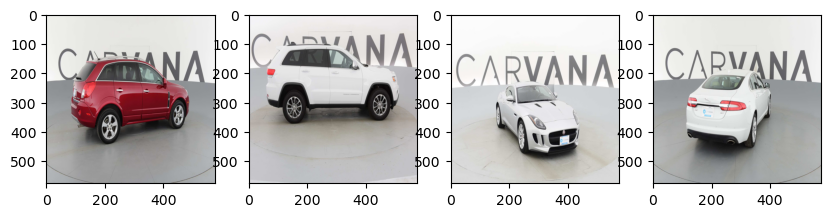

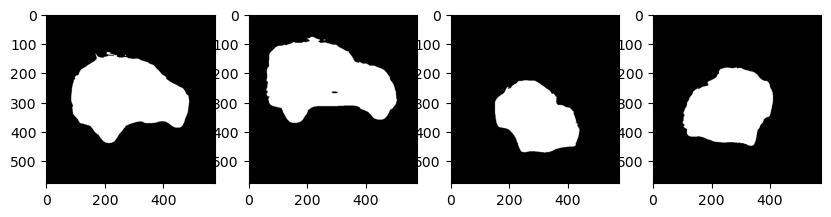

In [21]:
def visualize_result(dataloader):
    """
    Show images and predictions
    """
    tr_imgs = []
    msk_imgs = []

    for x, y in dataloader:
        x = x.to(device)

        pred = model(x)

        for i in range(x.shape[0]):
            tr_img = x[i].cpu().detach().numpy()
            tr_img = np.einsum('kij->ijk', tr_img)
            tr_imgs.append(tr_img)

            msk_img = pred[i].cpu().detach().numpy()
            msk_img = msk_img.reshape((img_size, img_size))
            msk_imgs.append(msk_img)

        break

    plot_images(tr_imgs, mask=False)
    plot_images(msk_imgs, mask=True)


visualize_result(val_dataloader)

In [22]:
torch.save(model.state_dict(), "model.pth")

In [23]:
def rle(img):
    """
    Run-length encoding (RLE)
    Lossless compression method where sequences that display redundant data 
    are stored as a single data value representing the repeated block and how 
    many times it appears in the image.
    """
    flat_img = img.flatten()
    flat_img = np.where(flat_img > 0.5, 1, 0).astype(np.uint8)
    flat_img = np.insert(flat_img, [0, len(flat_img)], [0, 0])

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 1
    ends_ix = np.where(ends)[0] + 1
    lengths = ends_ix - starts_ix

    encoding = ''
    for idx in range(len(starts_ix)):
        encoding += '%d %d ' % (starts_ix[idx], lengths[idx])
    return encoding.strip()

In [25]:
# TODO: This requires test.zip
# test_rle = np.zeros((test_images.shape[0]), dtype=object)

# shape = test_images.shape[0]
# print(f"Test images shape: {shape}, la: {test_images.shape}")
# # Test images shape: 100064, la: (100064,)

# start_time = time.time()

# for i in range(shape):
#     img = np.array(Image.open("/kaggle/working/test/" + test_images[i]))
#     test_rle[i] = rle(img)

#     if i % 1000 == 0:
#         print(i)  # 1000, 2000, etc.

# print("\n--- %s minutes ---" % (time.time() - start_time) / 60)

In [26]:
# df_ans = pd.DataFrame({"img": test_images, "rle_mask": test_rle})

# df_ans.head()  # 100064 rows × 2 columns

,img,rle_mask
0,0004d4463b50_01.jpg,1 2177145 2177149 97785 2274937 30021 2304959 ...
1,0004d4463b50_02.jpg,1 2148250 2148253 109260 2257514 1 2257516 427...
2,0004d4463b50_03.jpg,1 2172979 2172981 586898 2759881 20784 2780671...
3,0004d4463b50_04.jpg,1 2339995 2339997 296830 2636830 11484 2648316...
4,0004d4463b50_05.jpg,1 2246363 2246365 189620 2435986 74735 2510722...


In [ ]:
# Print to CSV file
# df_ans.to_csv("ans1.csv", index=False)